In [46]:
%reload_ext autoreload
%autoreload 2

import hashlib
from operator import truediv
from firebase_admin import db
from library.firebase import initialize_app, get_dataset_ref
from library.design_space import get_design_space
import numpy as np
from sherlock.utils import approximate_pareto
import matplotlib.pyplot as plt
import math
import dateutil.parser
from datetime import datetime

VIDEO_FILES = [
    "VISO/car/003",
    "VISO/car/004",
    "VISO/car/005",
    "VISO/car/006",
    "VISO/car/007",
    "VISO/car/008",
    "VISO/car/009",
]

enable_tracking = True
enable_persist = False

initialize_app()

def get_row_col(i: int):
    col = i % 3
    row = math.floor(i / 3)

    return (row, col)

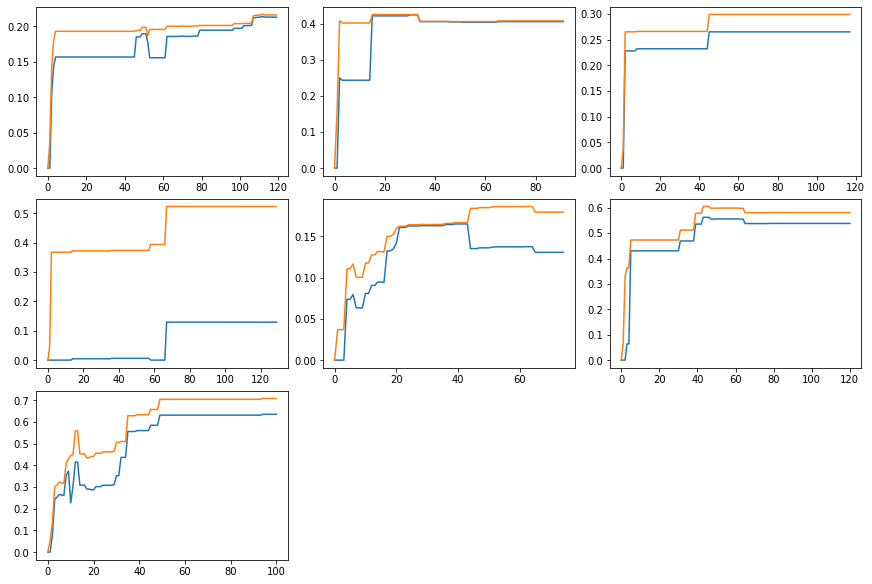

In [47]:
with open("./config_declaration.yml", "rb") as f:
    config_hash = hashlib.md5(f.read()).hexdigest()

sherlock_ref = db.reference("sherlock")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), constrained_layout=True)
fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])
for idx, video_file in enumerate(VIDEO_FILES):
    r, c = get_row_col(idx)
    X, y, current_idx, known_idx = get_design_space(video_file, enable_tracking, enable_persist)

    current_idx = np.array(current_idx)

    areas1 = [0]
    areas2 = [0]
    for i in range(1,current_idx.shape[0]):
        partial_idx = current_idx[:i]
        partial_outputs = np.array(y[partial_idx, :])
        partial_outputs_order = np.argsort(partial_outputs[:, 0])
        partial_outputs = partial_outputs[partial_outputs_order, :]

        ypredict, _, _ = approximate_pareto(partial_outputs)

        area = np.trapz(ypredict[:, 1], x=ypredict[:, 0])
        areas1.append(area)
        area += ypredict[0, 0] * ypredict[0, 1]
        areas2.append(area)

    axs[r, c].plot(areas1)
    axs[r, c].plot(areas2)


In [50]:
with open("./config_declaration.yml", "rb") as f:
    config_hash = hashlib.md5(f.read()).hexdigest()

sherlock_ref = db.reference("sherlock")

for idx, video_file in enumerate(VIDEO_FILES):
    r, c = get_row_col(idx)
    X, y, current_idx, known_idx = get_design_space(video_file, enable_tracking, enable_persist)

    current_idx = np.array(current_idx)
    current_outputs = np.array(y[current_idx, :])

    ypredict, ypredict_idx, _ = approximate_pareto(current_outputs)
    ypredict_idx = current_idx[ypredict_idx]

    current_idx = list(current_idx)
    current_idx.reverse()

    video_file_ref = get_dataset_ref(video_file, sherlock_ref)
    config_declaration_ref = video_file_ref.child(config_hash)

    if enable_tracking:
        tracking_ref = config_declaration_ref.child("tracking_enabled")
    else:
        tracking_ref = config_declaration_ref.child("tracking_disabled")

    if enable_persist:
        persist_ref = tracking_ref.child("persist_enabled")
    else:
        persist_ref = tracking_ref.child("persist_disabled")

    last_update_ref = persist_ref.child("last_update")
    last_update = dateutil.parser.isoparse(last_update_ref.get())
    now = datetime.utcnow()

    for j, i in enumerate(current_idx):
        if i in ypredict_idx:
            print(f"Video {idx + 1} samples since last pareto optimal: {j}|{float(j) * 100.0 / float(len(current_idx)):.2f}% (Updated {(now - last_update).total_seconds() / 60: .2f} minutes ago)")
            break


Video 1 samples since last pareto optimal: 0|0.00% (Updated  0.97 minutes ago)
Video 2 samples since last pareto optimal: 26|28.26% (Updated  9.82 minutes ago)
Video 3 samples since last pareto optimal: 73|61.86% (Updated  18.89 minutes ago)
Video 4 samples since last pareto optimal: 57|43.51% (Updated  5.26 minutes ago)
Video 5 samples since last pareto optimal: 0|0.00% (Updated  27.18 minutes ago)
Video 6 samples since last pareto optimal: 44|36.07% (Updated  4.13 minutes ago)
Video 7 samples since last pareto optimal: 1|0.99% (Updated  25.94 minutes ago)


 0.91
 0.79
 0.82
 0.85
 0.67
 0.83
 0.39


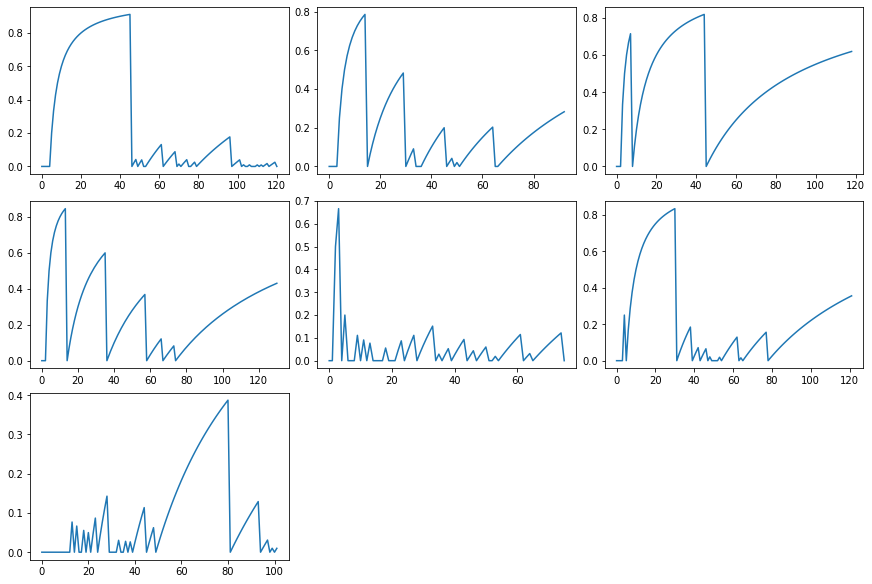

In [49]:
with open("./config_declaration.yml", "rb") as f:
    config_hash = hashlib.md5(f.read()).hexdigest()

sherlock_ref = db.reference("sherlock")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), constrained_layout=True)
fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])
for idx, video_file in enumerate(VIDEO_FILES):
    r, c = get_row_col(idx)
    X, y, current_idx, known_idx = get_design_space(video_file, enable_tracking, enable_persist)

    current_idx = np.array(current_idx)

    scores = [0]
    for i in range(current_idx.shape[0]):
        partial_idx = current_idx[:(i+1)]
        partial_outputs = np.array(y[partial_idx, :])

        ypredict, ypredict_idx, _ = approximate_pareto(partial_outputs)
        ypredict_idx = partial_idx[ypredict_idx]

        partial_idx = list(partial_idx)
        partial_idx.reverse()

        for j, k in enumerate(partial_idx):
            if k in ypredict_idx:
                score = float(j) / float(len(partial_idx))
                scores.append(score)
                break

    axs[r, c].plot(scores)
    print(f"{max(scores): .2f}")
